<a href="https://colab.research.google.com/github/afsara-mir/100daysofcoding/blob/main/emote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pydub
!pip install noisereduce

In [ ]:
%%capture
import os
import numpy as np

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display
import IPython.display as ipd

In [ ]:
%%capture
!pip install deeplake

In [ ]:
import deeplake
ds = deeplake.load("hub://activeloop/ravdess-emotional-speech-audio")

In [ ]:
!pip install torch

In [ ]:
dataloader = ds.pytorch(num_workers=0, batch_size=4, shuffle=False)

In [ ]:
ds.visualize()

In [ ]:
path= '/content/03-01-01-01-02-01-01.wav'

In [ ]:
!pip3 install librosa

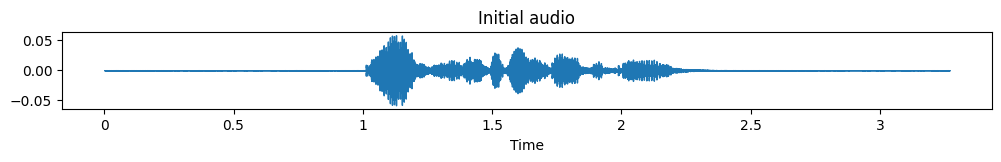

In [ ]:
rawsound = AudioSegment.from_file(path)
x, sr = librosa.load(path, sr = None)

plt.figure(figsize=(12,1))
librosa.display.waveshow(x, sr=sr)
plt.title('Initial audio')

rawsound

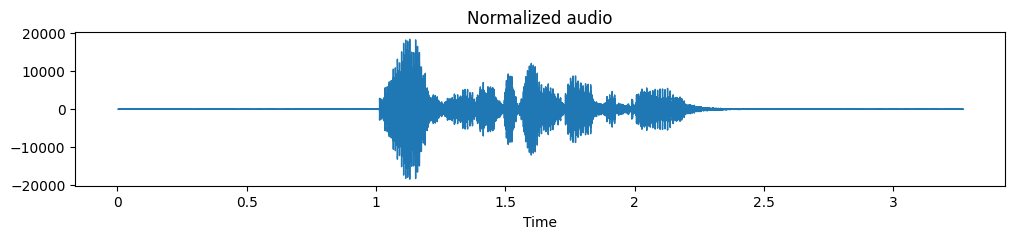

In [ ]:
normalizedsound = effects.normalize(rawsound, headroom = 5.0)
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

plt.figure(figsize=(12,2))
librosa.display.waveshow(normal_x, sr=sr)
plt.title('Normalized audio')

normalizedsound

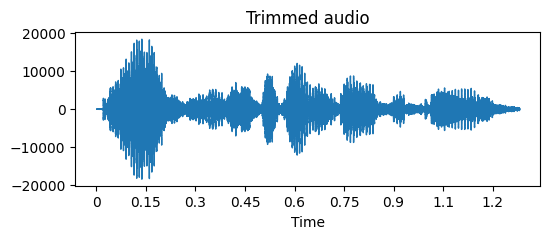

In [ ]:
xt, index = librosa.effects.trim(normal_x, top_db = 30)

plt.figure(figsize=(6,2))
librosa.display.waveshow(xt, sr=sr)
plt.title('Trimmed audio')

ipd.display(ipd.Audio(data = xt, rate=sr))

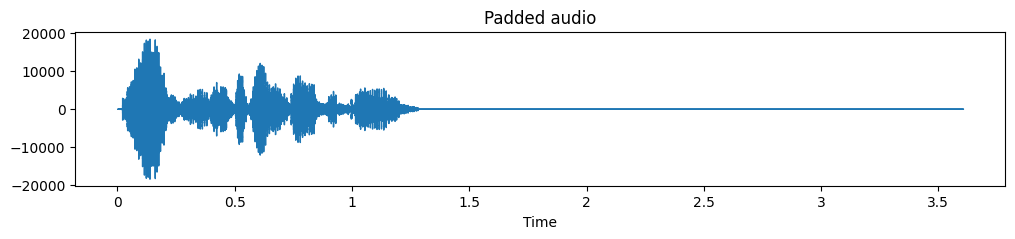

In [ ]:
padded_x = np.pad(xt, (0, 173056-len(xt)), 'constant')

plt.figure(figsize=(12,2))
librosa.display.waveshow(padded_x, sr=sr)
plt.title('Padded audio')

ipd.display(ipd.Audio(data = padded_x, rate=sr))

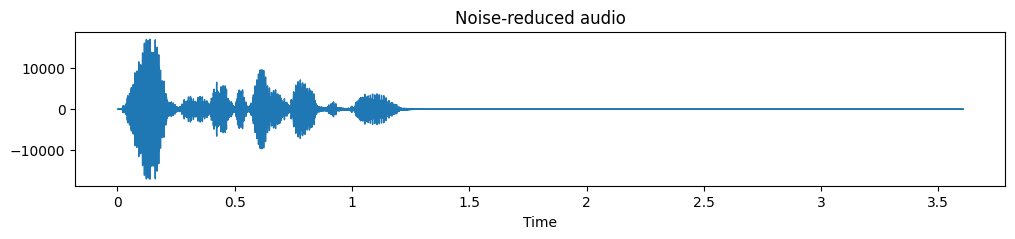

In [ ]:
final_x = nr.reduce_noise(y=padded_x,
                          y_noise=padded_x,
                          sr=sr)

plt.figure(figsize=(12,2))
librosa.display.waveshow(final_x, sr=sr)
plt.title('Noise-reduced audio')

ipd.display(ipd.Audio(data = final_x, rate=sr))

**Model building**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [ ]:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
%%capture
sample_lengths = []
folder_path = '/content/drive/My Drive/emotional-data-archive'

# files = os.listdir(folder_path)
# print(files)

print(list(os.walk(folder_path)))
for subdir, dirs, files in os.walk(folder_path):
  # print(dirs)
  for file in files:
    # print(os.path.join(subdir,file))
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

# Extaction Data

In [ ]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/My Drive/emotional-data-archive'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0)
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
    # Pad for duration equalization.
      padded_x = np.pad(xt, (0, max(0, total_length - len(xt))), 'constant')[:total_length]
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22

   # Features extraction
      f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
      f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length) # ZCR
      f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length) # MFCC
      name = file[6:8]
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) # Assuming 'emotionfix' function corrects/assigns emotion based on filename or other criteria

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 11.2473 minutes


In [ ]:
f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (2880, 339, 1)
RMS shape: (2880, 339, 1)
MFCCs shape: (2880, 339, 13)


In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
x_data = X.tolist()
x_path = '/content/drive/My Drive/Colab Notebooks/X_data_new.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = '/content/drive/My Drive/Colab Notebooks/Y_data_new.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[6], [3], [0], [5], [3], [4], [0], [4], [5], [3], [5], [5], [3], [1], [2], [2], [3], [4], [2], [2], [4], [1], [5], [0], [4], [4], [2], [2], [1], [3], [4], [1], [5], [3], [4], [0], [3], [1], [5], [1], [2], [6], [1], [5], [2], [1], [7], [7], [7], [7], [6], [7], [6], [7], [7], [6], [6], [7], [6], [6], [3], [0], [2], [3], [1], [4], [4], [0], [2], [1], [3], [4], [4], [4], [2], [4], [2], [3], [2], [2], [4], [3], [0], [2], [3], [1], [1], [1], [0], [3], [2], [1], [3], [4], [1], [1], [5], [5], [6], [6], [5], [7], [6], [5], [6], [5], [7], [6], [6], [7], [7], [7], [7], [5], [6], [5], [5], [6], [7], [7], [3], [0], [3], [2], [5], [0], [4], [6], [5], [4], [1], [4], [2], [0], [5], [5], [3], [1], [1], [3], [5], [1], [1], [2], [4], [0], [3], [2], [5], [2], [6], [6], [5], [4], [1], [1], [2], [6], [2], [3], [4], [3], [5], [3], [4], [2], [1], [4], [6], [7], [7], [6], [7], [7], [6], [7], [7], [7], [6], [7], [1], [2], [4], [4], [3], [0], [4], [2], [2], [4], [4], [3], [1], [5], [5], [5], [4], [1], [1], [3]

In [ ]:
x_data = X.tolist()
x_path = '/content/drive/My Drive/Colab Notebooks/X_data_new.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = '/content/drive/My Drive/Colab Notebooks/Y_data_new.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[6], [3], [0], [5], [3], [4], [0], [4], [5], [3], [5], [5], [3], [1], [2], [2], [3], [4], [2], [2], [4], [1], [5], [0], [4], [4], [2], [2], [1], [3], [4], [1], [5], [3], [4], [0], [3], [1], [5], [1], [2], [6], [1], [5], [2], [1], [7], [7], [7], [7], [6], [7], [6], [7], [7], [6], [6], [7], [6], [6], [3], [0], [2], [3], [1], [4], [4], [0], [2], [1], [3], [4], [4], [4], [2], [4], [2], [3], [2], [2], [4], [3], [0], [2], [3], [1], [1], [1], [0], [3], [2], [1], [3], [4], [1], [1], [5], [5], [6], [6], [5], [7], [6], [5], [6], [5], [7], [6], [6], [7], [7], [7], [7], [5], [6], [5], [5], [6], [7], [7], [3], [0], [3], [2], [5], [0], [4], [6], [5], [4], [1], [4], [2], [0], [5], [5], [3], [1], [1], [3], [5], [1], [1], [2], [4], [0], [3], [2], [5], [2], [6], [6], [5], [4], [1], [1], [2], [6], [2], [3], [4], [3], [5], [3], [4], [2], [1], [4], [6], [7], [7], [6], [7], [7], [6], [7], [7], [7], [6], [7], [1], [2], [4], [4], [3], [0], [4], [2], [2], [4], [4], [3], [1], [5], [5], [5], [4], [1], [1], [3]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, num_classes=8).astype('int8')
y_val_class = tf.keras.utils.to_categorical(y_val, num_classes=8).astype('int8')

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(2520, 339, 15)
(250, 339, 15)
(110, 339, 15)


In [ ]:
file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[6], [2], [6], [5], [7], [3], [1], [7], [6], [2], [1], [0], [6], [3], [6], [4], [1], [7], [4], [6], [7], [6], [4], [5], [0], [3], [3], [7], [5], [0], [1], [2], [7], [1], [1], [4], [6], [1], [4], [4], [7], [0], [5], [6], [5], [4], [5], [7], [7], [3], [6], [0], [7], [1], [1], [4], [5], [3], [7], [2], [7], [4], [7], [3], [4], [2], [2], [5], [7], [2], [7], [5], [5], [7], [3], [0], [2], [1], [5], [6], [6], [6], [4], [7], [5], [7], [2], [5], [3], [2], [0], [5], [1], [1], [4], [5], [5], [4], [3], [2], [4], [6], [7], [3], [0], [1], [3], [1], [1], [1]], "dtype": "int8", "shape": [110, 1], "Corder": true}'

In [ ]:
%%capture
!pip install keras

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks

In [ ]:

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights_new.keras'

# Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                                     monitor='val_categorical_accuracy',
                                     mode='max')
# Reduce learning rate after 100 epochs without improvement
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)

# Compile & train the model
model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                    epochs=340, batch_size=batch_size,
                    validation_data=(x_val, y_val_class),
                    callbacks=[mcp_save, rlrop])

# Load the best weights to the model
model.load_weights(checkpoint_path)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 339, 64)             │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 373ms/step - categorical_accuracy: 0.1324 - loss: 2.0823 - val_categorical_accuracy: 0.1440 - val_loss: 2.0639 - learning_rate: 0.0010
Epoch 2/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 379ms/step - categorical_accuracy: 0.1765 - loss: 2.0441 - val_categorical_accuracy: 0.1720 - val_loss: 2.0036 - learning_rate: 0.0010
Epoch 3/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 379ms/step - categorical_accuracy: 0.1877 - loss: 2.0183 - val_categorical_accuracy: 0.1760 - val_loss: 2.0247 - learning_rate: 0.0010
Epoch 4/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 78s 347ms/step - categorical_accuracy: 0.2052 - loss: 2.0117 - val_categorical_accuracy: 0.1920 - val_loss: 1.9398 - learning_rate: 0.0010
Epoch 5/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - categorical_accuracy: 0.2143 - loss: 1.9678 - val_categorical_accuracy: 0.2120 - val_loss: 1.9590 - learning_rate: 0.0010
Epoch 6/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 367ms/step - categorical_accuracy: 0.2010 - loss: 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

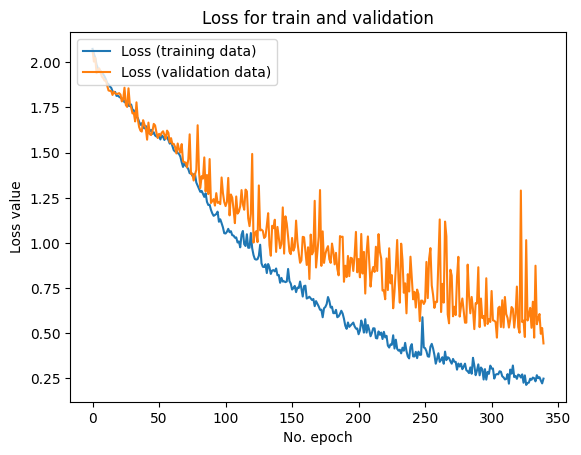

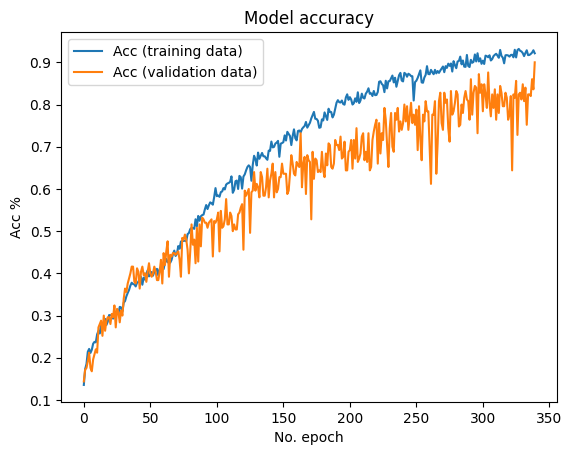

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
import pandas as pd

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.9167
calm : 0.9268
happy : 0.8750
sad : 0.8750
angry : 0.9375
fearful : 0.8333
disgust : 0.8780
surprised : 0.9667


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_new.weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


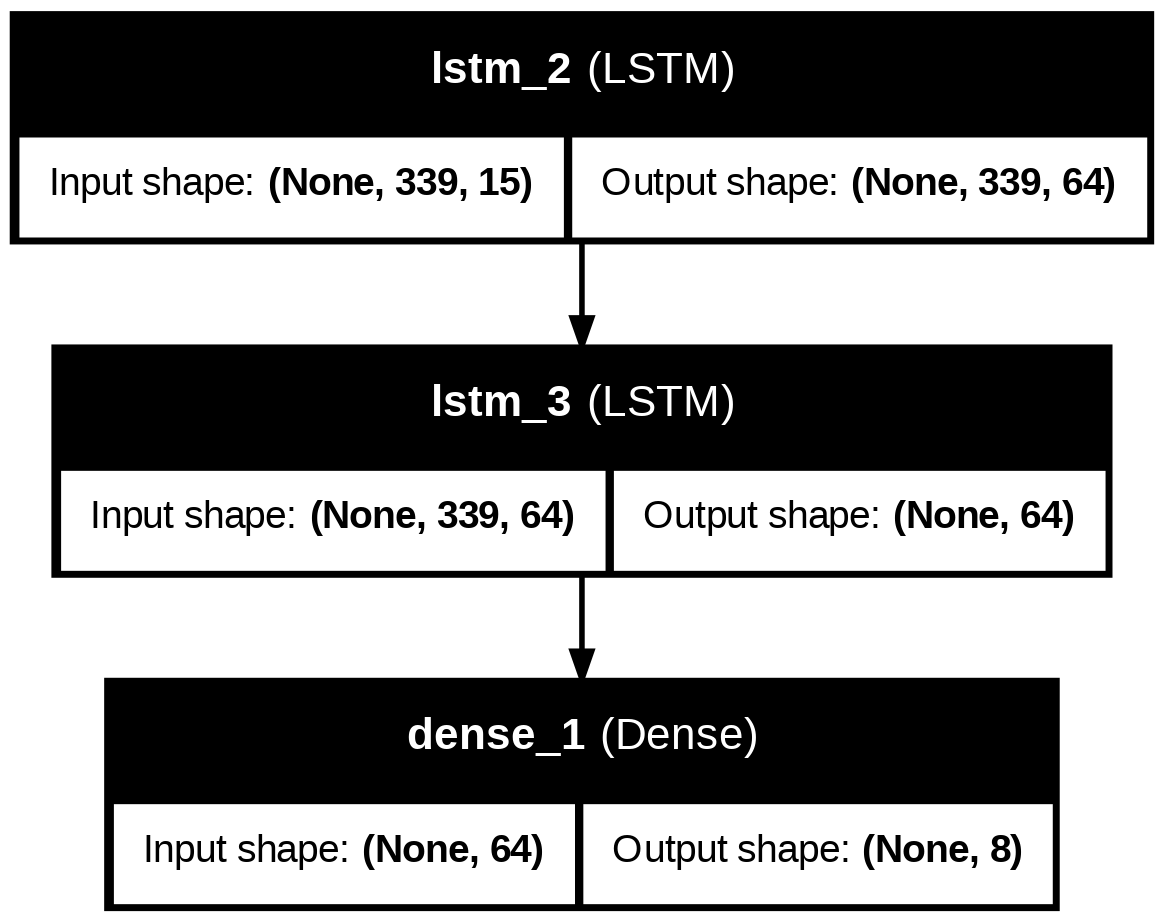

In [ ]:
# Reading the model from JSON file

saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_new.weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, num_classes=8).astype('int8')


In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

4/4 - 1s - 291ms/step - categorical_accuracy: 0.8636 - loss: 0.5217


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

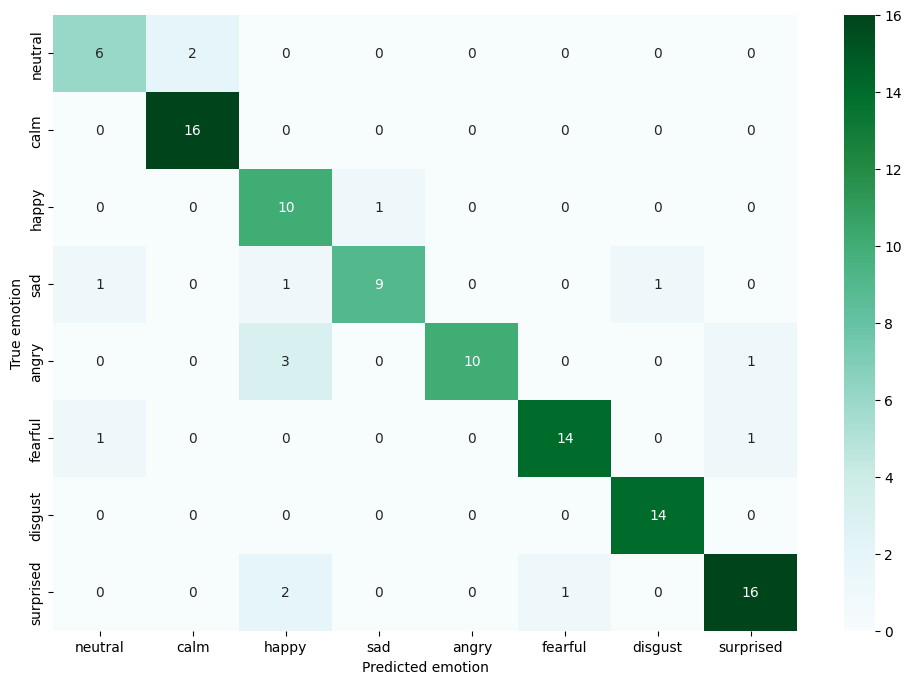

In [ ]:

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.7500
calm : 1.0000
happy : 0.9091
sad : 0.7500
angry : 0.7143
fearful : 0.8750
disgust : 1.0000
surprised : 0.8421


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install pyaudio
!pip install json-tricks

In [ ]:
%%capture
import os
from json_tricks import load

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model

import matplotlib.pyplot as plt

In [ ]:
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_new.weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 339, 64)             │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    '''
    A process to an audio .wav file before execcuting a prediction.
      Arguments:
      - file_path - The system path to the audio file.
      - frame_length - Length of the frame over which to compute the speech features. default: 2048
      - hop_length - Number of samples to advance for each frame. default: 512

      Return:
        'X_3D' variable, containing a shape of: (batch, timesteps, feature) for a single file (batch = 1).
    '''
    # Fetch sample rate.
    _, sr = librosa.load(path = file_path, sr = None)
    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration = None)
    # Normalize to 5 dBFS
    normalizedsound = effects.normalize(rawsound, headroom = 5.0)
    # Transform the audio file to np.array of samples
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Noise reduction
    final_x = nr.reduce_noise(normal_x, sr=sr, use_tensorflow=True)


    f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,center=True).T # ZCR
    f3 = librosa.feature.mfcc(final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length).T # MFCC
    X = np.concatenate((f1, f2, f3), axis = 1)

    X_3D = np.expand_dims(X, axis=0)

    return X_3D

In [ ]:
# Emotions list is created for a readable form of the model prediction.

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100

In [ ]:
%%capture


In [ ]:
import pyaudio
import wave
from array import array
import struct
import time

# Initialize variables
RATE = 24414
CHUNK = 512
RECORD_SECONDS = 7.1

FORMAT = pyaudio.paInt32
CHANNELS = 1
WAVE_OUTPUT_FILE = "/content/drive/My Drive/Colab Notebooks/output.wav"

# Open an input channel
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)


# Initialize a non-silent signals array to state "True" in the first 'while' iteration.
data = array('h', np.random.randint(size = 512, low = 0, high = 500))

# SESSION START
print("** session started")
total_predictions = [] # A list for all predictions in the session.
tic = time.perf_counter()

while is_silent(data) == False:
    print("* recording...")
    frames = []
    data = np.nan # Reset 'data' variable.

    timesteps = int(RATE / CHUNK * RECORD_SECONDS) # => 339

    # Insert frames to 'output.wav'.
    for i in range(0, timesteps):
        data = array('l', stream.read(CHUNK))
        frames.append(data)

        wf = wave.open(WAVE_OUTPUT_FILE, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

    print("* done recording")

    x = preprocess(WAVE_OUTPUT_FILE) # 'output.wav' file preprocessing.
    # Model's prediction => an 8 emotion probabilities array.
    predictions = model.predict(x, use_multiprocessing=True)
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statments.
    total_predictions.append(pred_np)

    # Present emotion distribution for a sequence (7.1 secs).
    fig = plt.figure(figsize = (10, 2))
    plt.bar(emo_list, pred_np, color = 'darkturquoise')
    plt.ylabel("Probabilty (%)")
    plt.show()

    max_emo = np.argmax(predictions)
    print('max emotion:', emotions.get(max_emo,-1))

    print(100*'-')

    # Define the last 2 seconds sequence.
    last_frames = np.array(struct.unpack(str(96 * CHUNK) + 'B' , np.stack(( frames[-1], frames[-2], frames[-3], frames[-4],
                                                                            frames[-5], frames[-6], frames[-7], frames[-8],
                                                                            frames[-9], frames[-10], frames[-11], frames[-12],
                                                                            frames[-13], frames[-14], frames[-15], frames[-16],
                                                                            frames[-17], frames[-18], frames[-19], frames[-20],
                                                                            frames[-21], frames[-22], frames[-23], frames[-24]),
                                                                            axis =0)) , dtype = 'b')
    if is_silent(last_frames): # If the last 2 seconds are silent, end the session.
        break

# SESSION END
toc = time.perf_counter()
stream.stop_stream()
stream.close()
p.terminate()
wf.close()
print('** session ended')

# Present emotion distribution for the whole session.
total_predictions_np =  np.mean(np.array(total_predictions).tolist(), axis=0)
fig = plt.figure(figsize = (10, 5))
plt.bar(emo_list, total_predictions_np, color = 'indigo')
plt.ylabel("Mean probabilty (%)")
plt.title("Session Summary")
plt.show()

print(f"Emotions analyzed for: {(toc - tic):0.4f} seconds")

ModuleNotFoundError: No module named 'pyaudio'